# **0.Import libraries**

In [1]:
from dataset import load_dataset
# from models.model_2_dropout_imp import ClimatePINN
from train import plot_comparison
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import xarray as xr
from visualisation import visualize_predictions
import json
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm
%matplotlib inline

# **1.Load data**

In [9]:
dataset = load_dataset(
    1, 
    train_val_split = None, 
    year0=2000, 
    root_dir="./data/era_5_data",
    normalize=True)

idx = [0,1,2]
inputs, targets = dataset['train'][:]['input'], dataset['train'][:]['target']
geo500 , t850 = inputs[:,0,...], inputs[:,1,...]
t2m, u, v = targets[:,0,...], targets[:,1,...], targets[:,2,...]
inputs = (geo500 , t850)
targets = (t2m, u, v)
lon, lat= dataset['train'][0]['coords'][0], dataset['train'][0]['coords'][1]

Grid files loaded


In [ ]:
vars = (geo500 , t850, t2m, u, v)

corr_matrix = np.zeros((5,5))
vars_name = ['input:geo500', 'input:t850', 'target:t2m', 'target:u', 'target:v']
corr_matrix = np.zeros((5, 5, 32, 64))
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-1, vmax=1)
for x, var_x in tqdm(enumerate(vars)):
    for y, var_y in enumerate(vars):
        corr = pearsonr(var_x, var_y)[0]
        corr_matrix[x,y] = corr

5it [00:05,  1.19s/it]


# **2.Correlation**

5it [00:05,  1.06s/it]


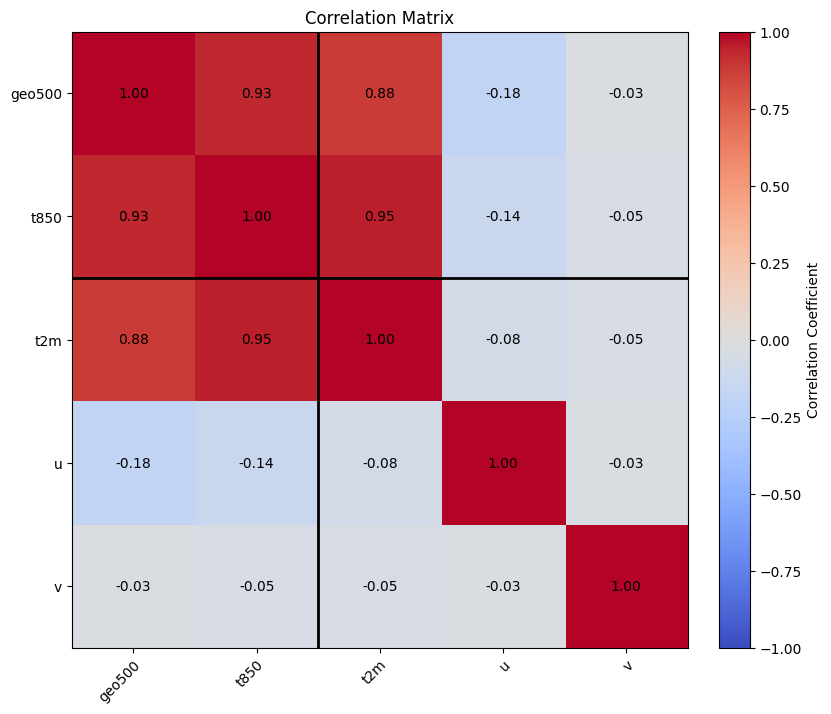

In [8]:
# Flatten the arrays
vars = (geo500.flatten(), t850.flatten(), t2m.flatten(), u.flatten(), v.flatten())
vars_name = ['geo500', 't850', 't2m', 'u', 'v']

# Compute the correlation matrix
corr_matrix = np.zeros((5, 5))
for x, var_x in tqdm(enumerate(vars)):
    for y, var_y in enumerate(vars):
        corr = pearsonr(var_x, var_y)[0]
        corr_matrix[x, y] = corr

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correlation matrix
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient')

# Add labels to the matrix
ax.set_xticks(np.arange(len(vars_name)))
ax.set_yticks(np.arange(len(vars_name)))
ax.set_xticklabels(vars_name)
ax.set_yticklabels(vars_name)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add separators
ax.axvline(x=1.5, color='black', linewidth=2)
ax.axhline(y=1.5, color='black', linewidth=2)

# Annotate the cells with the correlation coefficients
for i in range(len(vars_name)):
    for j in range(len(vars_name)):
        text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()

In [10]:
torch.load('checkpoints/model_2/model_2.pt')

/tmp/ipykernel_15212/389446608.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('checkpoints/model_2/model_2.pt')


{'epoch': 48,
 'model_state_dict': OrderedDict([('log_re', tensor(4.9274, device='cuda:0')),
              ('meteo_encoder.cnn.0.weight',
               tensor([[[[-0.1235, -0.0777,  0.1065],
                         [ 0.2274, -0.1450, -0.0918],
                         [-0.0278,  0.0969,  0.1847]],
               
                        [[ 0.0657,  0.1137, -0.0179],
                         [ 0.0283, -0.1527, -0.1224],
                         [-0.0827,  0.1741, -0.0968]]],
               
               
                       [[[ 0.0112,  0.1025, -0.1341],
                         [-0.2940, -0.1833,  0.2686],
                         [-0.0546, -0.0499,  0.1982]],
               
                        [[ 0.1360, -0.0283, -0.0891],
                         [ 0.0506,  0.2013, -0.1450],
                         [ 0.1293, -0.0751, -0.1943]]],
               
               
                       [[[-0.0663, -0.1670,  0.3006],
                         [-0.0333, -0.1629,  0.1318],
    